# NLP Text Classifier

This project implements a text classification model using TensorFlow. The model preprocesses text data, removes stopwords, and trains a neural network to classify text into predefined categories.



In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import optuna
import pickle

In [2]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    """Stop training once accuracy reaches 90% on both training and validation sets, with a patience mechanism."""
    
    def __init__(self, patience=2):
        super(EarlyStoppingCallback, self).__init__()
        self.patience = patience
        self.best_val_accuracy = 0
        self.wait = 0  

    def on_epoch_end(self, epoch, logs=None):
        current_val_accuracy = logs.get('val_accuracy')  

        if current_val_accuracy is not None:
            if current_val_accuracy > self.best_val_accuracy:
                self.best_val_accuracy = current_val_accuracy 
                self.wait = 0 
            else:
                self.wait += 1  

            if self.wait >= self.patience:
                self.model.stop_training = True
                print(f"Early stopping: validation accuracy did not improve for {self.patience} epochs.")

        if logs.get('accuracy') >= 0.9 and current_val_accuracy >= 0.9:
            self.model.stop_training = True
            print("Reached 90% accuracy on both training and validation, stopping training.")

In [3]:
VOCAB_SIZE = 1000
TRAINING_SPLIT = 0.8

In [4]:
data_dir = "data/articles.csv"
data = np.loadtxt(data_dir, delimiter=',', skiprows=1, dtype='str', comments=None)
max_length = max(len(content.split()) for content in data[:,1])
print(f"Shape of the data: {data.shape}")
print(f"{data[0]}\n{data[1]}")


Shape of the data: (2225, 2)
['tech'
 'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv

In [5]:
def train_val_datasets(data):
    '''
    Splits data into traning and validations sets
    
    Args:
        data (np.array): array with two columns, first one is the label, the second is the text
    
    Returns:
        (tf.data.Dataset, tf.data.Dataset): tuple containing the train and validation datasets
    '''
    TRAINING_SPLIT = 0.8 
    
    
    train_size = int(len(data) * TRAINING_SPLIT)

    texts = [data[i][1] for i in range(len(data))]
    labels = [data[i][0] for i in range(len(data))]

    train_texts = texts[:train_size]
    validation_texts = texts[train_size:]
    train_labels = labels[:train_size]
    validation_labels = labels[train_size:]
    
    train_dataset = tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
    validation_dataset = tf.data.Dataset.from_tensor_slices((validation_texts, validation_labels))
    
    
    return train_dataset, validation_dataset

In [6]:
train_dataset, validation_dataset = train_val_datasets(data)

print(f"There are {train_dataset.cardinality()} sentence-label pairs for training.\n")
print(f"There are {validation_dataset.cardinality()} sentence-label pairs for validation.\n")

There are 1780 sentence-label pairs for training.

There are 445 sentence-label pairs for validation.



In [7]:
def standardize_func(sentence):
    """
    Removes a list of stopwords
    
    Args:
        sentence (tf.string): sentence to remove the stopwords from
    
    Returns:
        sentence (tf.string): lowercase sentence without the stopwords
    """
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
                 "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could",
                 "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has",
                 "have", "having", "he", "her", "here",  "hers", "herself", "him", "himself", "his", "how",  "i", "if",
                 "in", "into", "is", "it", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of",
                 "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", 
                 "she",  "should", "so", "some", "such", "than", "that",  "the", "their", "theirs", "them", "themselves",
                 "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "very",
                 "was", "we",  "were", "what",  "when", "where", "which", "while", "who", "whom", "why", "why", "with", "would",
                 "you",  "your", "yours", "yourself", "yourselves", "'m",  "'d", "'ll", "'re", "'ve", "'s", "'d"]
 
    sentence = tf.strings.lower(sentence)
    
    for word in stopwords:
        if word[0] == "'":
            sentence = tf.strings.regex_replace(sentence, rf"{word}\b", "")
        else:
            sentence = tf.strings.regex_replace(sentence, rf"\b{word}\b", "")
    
    sentence = tf.strings.regex_replace(sentence, r'[!"#$%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\']', "")


    return sentence

In [8]:
def fit_vectorizer(train_sentences, standardize_func):
    '''
    Defines and adapts the text vectorizer

    Args:
        train_sentences (tf.data.Dataset): sentences from the train dataset to fit the TextVectorization layer
        standardize_func (FunctionType): function to remove stopwords and punctuation, and lowercase texts.
    Returns:
        TextVectorization: adapted instance of TextVectorization layer
    '''
    
    vectorizer = tf.keras.layers.TextVectorization( 
		standardize="lower_and_strip_punctuation",
		max_tokens=VOCAB_SIZE,
        output_sequence_length=max_length,
	) 
    
    train_sentences = train_sentences.map(lambda x: standardize_func(x))
    
    
    vectorizer.adapt(train_sentences)
    
    return vectorizer

In [9]:
text_only_dataset = train_dataset.map(lambda text, label: text)
vectorizer = fit_vectorizer(text_only_dataset, standardize_func)
vocab_size = vectorizer.vocabulary_size()

print(f"Vocabulary contains {vocab_size} words\n")

Vocabulary contains 1000 words



In [10]:
def fit_label_encoder(train_labels, validation_labels):
    """Creates an instance of a StringLookup, and trains it on all labels

    Args:
        train_labels (tf.data.Dataset): dataset of train labels
        validation_labels (tf.data.Dataset): dataset of validation labels

    Returns:
        tf.keras.layers.StringLookup: adapted encoder for train and validation labels
    """
    
    labels = train_labels.concatenate(validation_labels)

    label_encoder = tf.keras.layers.StringLookup(num_oov_indices=0)
    
    label_encoder.adapt(labels)
   
    
    return label_encoder

In [11]:
train_labels_only = train_dataset.map(lambda text, label: label)
validation_labels_only = validation_dataset.map(lambda text, label: label)

label_encoder = fit_label_encoder(train_labels_only,validation_labels_only)
                                  
print(f'Unique labels: {label_encoder.get_vocabulary()}')

Unique labels: ['sport', 'business', 'politics', 'tech', 'entertainment']


In [12]:
def preprocess_dataset(dataset, text_vectorizer, label_encoder):
    """Apply the preprocessing to a dataset

    Args:
        dataset (tf.data.Dataset): dataset to preprocess
        text_vectorizer (tf.keras.layers.TextVectorization ): text vectorizer
        label_encoder (tf.keras.layers.StringLookup): label encoder

    Returns:
        tf.data.Dataset: transformed dataset
    """
    
    def preprocess_text_label(text, label):

        text = text_vectorizer(text)
        
        label = tf.convert_to_tensor(label_encoder(label), dtype=tf.int64)
        
        return text, label

    dataset = dataset.map(preprocess_text_label)
    dataset = dataset.batch(32)

    return dataset


In [13]:
train_proc_dataset = preprocess_dataset(train_dataset, vectorizer, label_encoder)
validation_proc_dataset = preprocess_dataset(validation_dataset, vectorizer, label_encoder)



print(f"Number of batches in the train dataset: {train_proc_dataset.cardinality()}")
print(f"Number of batches in the validation dataset: {validation_proc_dataset.cardinality()}")

Number of batches in the train dataset: 56
Number of batches in the validation dataset: 14


In [14]:
train_batch = next(train_proc_dataset.as_numpy_iterator())
validation_batch = next(validation_proc_dataset.as_numpy_iterator())

print(f"Shape of the train batch: {train_batch[0].shape}")
print(f"Shape of the validation batch: {validation_batch[0].shape}")

Shape of the train batch: (32, 4492)
Shape of the validation batch: (32, 4492)


In [15]:
FILTERS = 320
KERNEL_SIZE = 5
LSTM_UNITS =128
EMBEDDING_DIM = 24
def create_model(EMBEDDING_DIM = EMBEDDING_DIM,FILTERS = FILTERS, KERNEL_SIZE = KERNEL_SIZE, act = 'relu', l1 = 256, drop = 0.4):
    """
    Creates a text classifier model
    Returns:
      tf.keras Model: the text classifier model
    """
    

	
    model = tf.keras.Sequential([ 
        tf.keras.Input(shape = (max_length,)),
        tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
        # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=LSTM_UNITS, return_sequences=True)),
        tf.keras.layers.Conv1D(FILTERS, KERNEL_SIZE-2, activation='relu'),
        tf.keras.layers.Conv1D(FILTERS*2, KERNEL_SIZE, activation='relu'),
        # tf.keras.layers.Conv1D(FILTERS*2, KERNEL_SIZE, activation='relu'),
        tf.keras.layers.GlobalAveragePooling1D(), 
        tf.keras.layers.Dropout(drop),
        tf.keras.layers.Dense(l1, activation=act),
        tf.keras.layers.Dense(5,activation ='softmax')
    ])
    


    return model

In [16]:
best_comb = []

def grid_search():
    Filters = [16,32,64]
    Kernel = [ 3,4,5,6]
    embed = [16,24,32,48]
    l1 = [ 64,128,192,256]
    act1 = ['relu','sigmoid']
    drop = [0.2,0.3,0.4]
    for f in Filters :
        for k in Kernel:
            for e in embed : 
                for l in l1 :
                    for act in act1 :
                        for d in drop : 
                            best_param = [f,k,e,l,act,d]
                            print(best_param)
                            model = create_model(EMBEDDING_DIM=e,KERNEL_SIZE=k,FILTERS=f,l1 = l,act =act,drop = d)
                            history = model.fit(train_proc_dataset, epochs=20, validation_data=validation_proc_dataset,callbacks=[EarlyStoppingCallback(patience = 2)],verbose= 0 )
                            model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
                            print (history.history['accuracy'][-1], history.history[f'val_accuracy'][-1]>=0.85)
                            if history.history['accuracy'][-1] >= 0.85 and history.history[f'val_accuracy'][-1]>=0.85 : 
                                print("--------------------------------------SAVED PARAMETERS--------------------------------")
                                best_comb.append(best_param)
    return best_comb

def objective(trial):
    # Define hyperparameters to tune
    f = trial.suggest_categorical('f',[16,32,64])
    k = trial.suggest_categorical('k',[ 3,4,5,6])
    e = trial.suggest_categorical('e',[16,24,32,48])
    l = trial.suggest_categorical('l',[ 64,128,192,256])
    act = trial.suggest_categorical('act',['relu','sigmoid'])
    d = trial.suggest_categorical('d',[0.2,0.3,0.4,0.5])


    model = create_model(EMBEDDING_DIM=e,KERNEL_SIZE=k,FILTERS=f,l1 = l,act =act,drop = d)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_proc_dataset, epochs=20, validation_data=validation_proc_dataset,callbacks=[EarlyStoppingCallback(patience = 2)],verbose= 0 )
    print()
    print(f,k,e,l,act,d)
    print (history.history['accuracy'][-1], history.history[f'val_accuracy'][-1])
    print('--------------------------------------------------------------------------------------------------------------')
    if history.history['accuracy'][-1] >= 0.85 and history.history[f'val_accuracy'][-1]>=0.85 : 
        best_param = [f,k,e,l,act,d]
        score = [history.history['accuracy'],history.history[f'val_accuracy'][-1]]
        f = best_param,score
        best_comb.append(f)
        print("--------------------------------------SAVED PARAMETERS--------------------------------")

    return history.history['val_accuracy'][-1]
        

In [17]:
# with tf.device('/GPU:0'):
#     study = optuna.create_study(direction='maximize')  
#     study.optimize(objective, n_trials=100) 
#     best_params =grid_search()
# # f': 64, 'k': 4, 'e': 48, 'l': 192, 'act': 'sigmoid', 'd': 0.3}
# print("Best optuna hyperparameters: ", study.best_params)         
# print(best_params)

In [18]:
model = create_model(EMBEDDING_DIM=16, FILTERS=300, KERNEL_SIZE=5, l1=64, act='relu', drop=0.3)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4492, 16)          16000     
                                                                 
 conv1d (Conv1D)             (None, 4490, 300)         14700     
                                                                 
 conv1d_1 (Conv1D)           (None, 4486, 600)         900600    
                                                                 
 global_average_pooling1d (G  (None, 600)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 600)               0         
                                                                 
 dense (Dense)               (None, 64)                38464     
                                                        

In [19]:
def adjust_learning_rate(model, min_lr=1e-6, max_lr=1, epochs=100):
    """Fit model using different learning rates to find optimal learning rate
    
    Args:
        model (tf.keras.Model): uncompiled model
        min_lr (float): minimum learning rate to test
        max_lr (float): maximum learning rate to test
        epochs (int): number of epochs to train
        
    Returns:
        tf.keras.callbacks.History: callback history
    """
    
    mult_factor = (max_lr / min_lr) ** (1/epochs)
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: min_lr * (mult_factor ** epoch)
    )
    
    optimizer = tf.keras.optimizers.Adam(min_lr)
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    
    history = model.fit(
        train_proc_dataset,
        epochs=epochs,
        callbacks=[lr_schedule],
        validation_data=validation_proc_dataset,
        verbose=1
    )
    
    return history



# lr_history = adjust_learning_rate(model=model)

# plt.figure(figsize=(10, 6))
# plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
# plt.grid(True)
# plt.xlabel("Learning Rate")
# plt.ylabel("Loss")
# plt.title("Learning Rate vs Loss")

# plt.xlim([1e-7, 1])
# plt.ylim([0, max(lr_history.history["loss"])])

# plt.figure(figsize=(10, 6))
# plt.semilogx(lr_history.history["lr"], lr_history.history["accuracy"])
# plt.grid(True)
# plt.xlabel("Learning Rate")
# plt.ylabel("Accuracy")
# plt.title("Learning Rate vs Accuracy")
# plt.xlim([1e-7, 1])

Epoch 1/50
56/56 [==============================] - 18s 313ms/step - loss: 1.5841 - accuracy: 0.2489 - val_loss: 1.4442 - val_accuracy: 0.3303
Epoch 2/50
56/56 [==============================] - 17s 306ms/step - loss: 0.9253 - accuracy: 0.5899 - val_loss: 0.6007 - val_accuracy: 0.7213
Epoch 3/50
56/56 [==============================] - 17s 305ms/step - loss: 0.4693 - accuracy: 0.8006 - val_loss: 0.3664 - val_accuracy: 0.8854
Epoch 4/50
56/56 [==============================] - 17s 305ms/step - loss: 0.2463 - accuracy: 0.9180 - val_loss: 0.2685 - val_accuracy: 0.9079
Epoch 5/50
56/56 [==============================] - 17s 305ms/step - loss: 0.1118 - accuracy: 0.9657 - val_loss: 0.2993 - val_accuracy: 0.9236
Epoch 6/50
56/56 [==============================] - 17s 304ms/step - loss: 0.0789 - accuracy: 0.9787 - val_loss: 0.4753 - val_accuracy: 0.9056
Epoch 7/50
56/56 [==============================] - 17s 305ms/step - loss: 0.0527 - accuracy: 0.9837 - val_loss: 0.2832 - val_accuracy: 0.9281

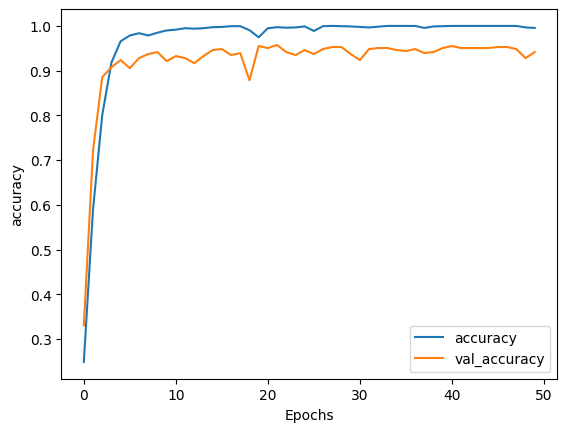

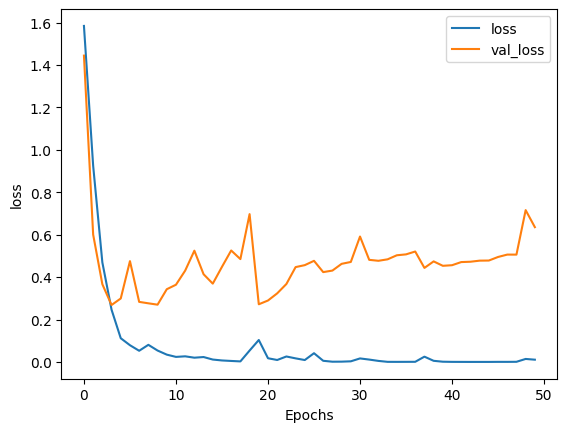

14min 10s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [20]:
%%timeit -n1 -r1
with tf.device('/GPU:0'):
    lr = 5e-3
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
        metrics=['accuracy']
    )
    history = model.fit(train_proc_dataset, epochs=50, validation_data=validation_proc_dataset)#,callbacks=[EarlyStoppingCallback(patience = 3)])


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history=history, metric="accuracy")
plot_graphs(history=history, metric="loss")

In [21]:
def predict(sentence):
    """
    Predict the label for a given sentence

    Args:
        sentence (str): input sentence to classify
        model (tf.keras.Model): trained text classification model

    Returns:
        str: predicted label for the input sentence
    """

    sentence = tf.expand_dims(input=sentence, axis=0)
    sentence = vectorizer(sentence)
    
    prediction = model.predict(sentence)
    print(prediction)
    predicted_label_index = tf.argmax(input=prediction, axis=1).numpy()[0]
    
    predicted_label = label_encoder.get_vocabulary()[predicted_label_index]
    
    return predicted_label, np.max(prediction)*100



In [22]:
def save(model):
    with open(file='model.pkl', mode='wb') as f:
        pickle.dump(obj=model, file=f)

In [23]:
def  load_model():
    with open(file='model.pkl', mode ='rb') as f:
        model = pickle.load(file=f)
    return model

In [24]:
save(model=model)
cont = True
while cont:
    sentence = input(prompt="Enter a sentence to classify, N to stop :")
    if sentence.capitalize().strip() == "N":
        cont = False 
        break
    
    predicted_label,proba = predict(sentence=sentence)
    print(f"The predicted label for the sentence is: {predicted_label} with a probability of {proba:.4f}%")

INFO:tensorflow:Assets written to: ram://6157f70a-2384-479a-bc3a-d978ce0ac3d6/assets


INFO:tensorflow:Assets written to: ram://6157f70a-2384-479a-bc3a-d978ce0ac3d6/assets


1/1 [==============================] - 0s 90ms/step
[[0.0000000e+00 1.3855459e-17 2.3063411e-18 1.0000000e+00 4.8617620e-33]]
The predicted label for the sentence is: tech with a probability of 100.0000%
